In [168]:
import pandas as pd
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import umap
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

latent_rep_path = os.path.join(base_dir, 'latent_representation.csv')
latent_rep = pd.read_csv(latent_rep_path, index_col='customer_id')

latent_rep_path_outliers = os.path.join(base_dir, 'latent_representation_outliers.csv')
latent_rep_outliers = pd.read_csv(latent_rep_path_outliers, index_col='customer_id')

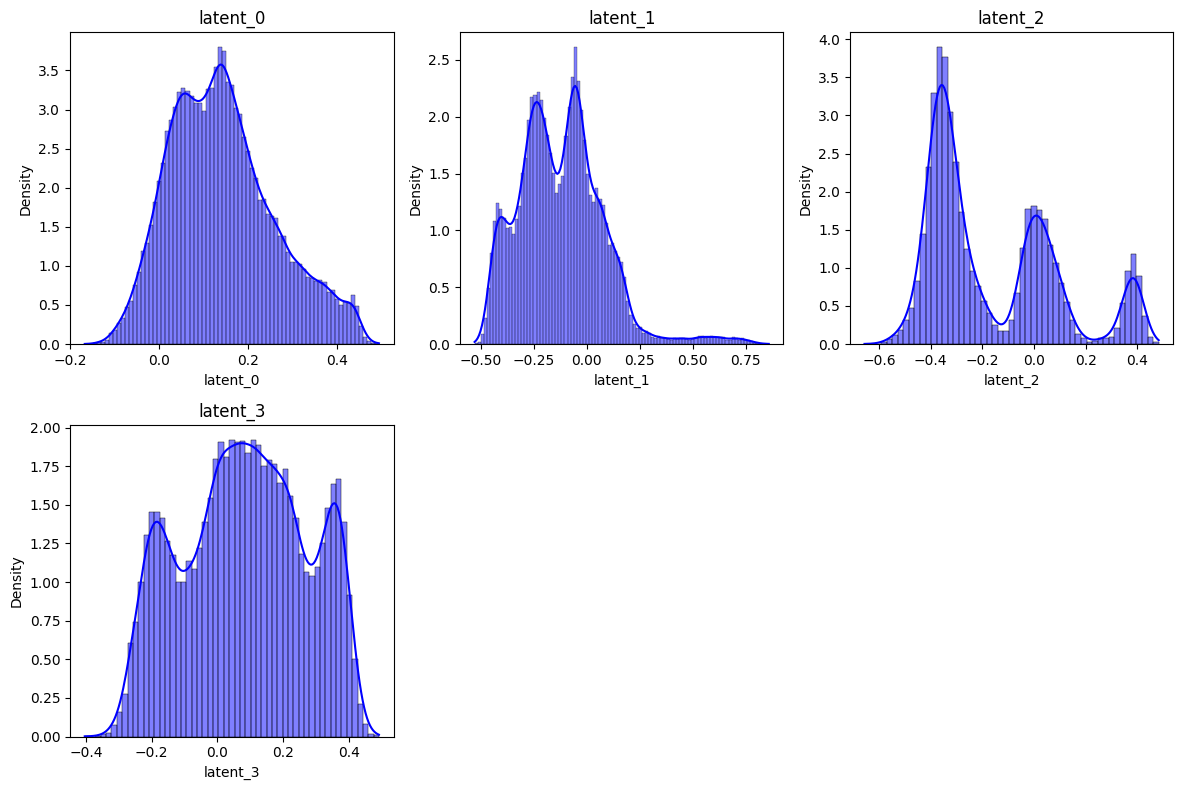

In [148]:
col_plotter(latent_rep)

In [169]:
scaler = RobustScaler()
latent_rep_scaled = pd.DataFrame(scaler.fit_transform(latent_rep), columns=latent_rep.columns, index=latent_rep.index)
latent_rep_scaled_outliers = pd.DataFrame(scaler.transform(latent_rep_outliers), columns=latent_rep.columns, index=latent_rep_outliers.index)

**Outliers Separated**

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kme

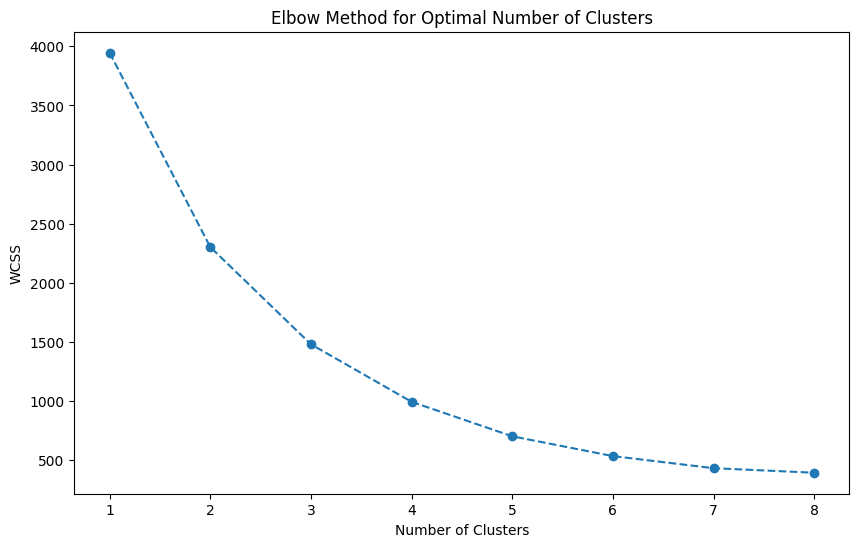

In [37]:
plot_elbow_method(latent_rep_scaled, max_clusters=8)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kme

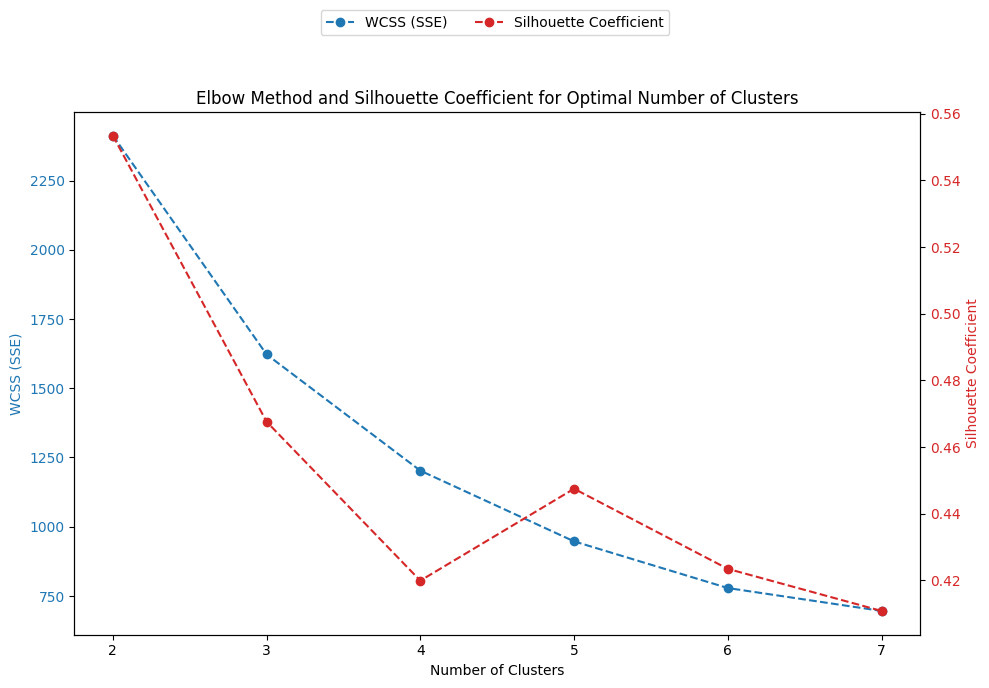

([2412.4577602908903,
  1622.1752029456825,
  1202.4729422476646,
  947.1334318260172,
  778.6248765811945,
  695.8658490874027],
 [0.5534488932670333,
  0.4676202122379906,
  0.41994354794010397,
  0.4475120102256088,
  0.42348458912793085,
  0.4108572852472836])

In [122]:
plot_elbow_and_silhouette(latent_rep_scaled, max_clusters=7)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


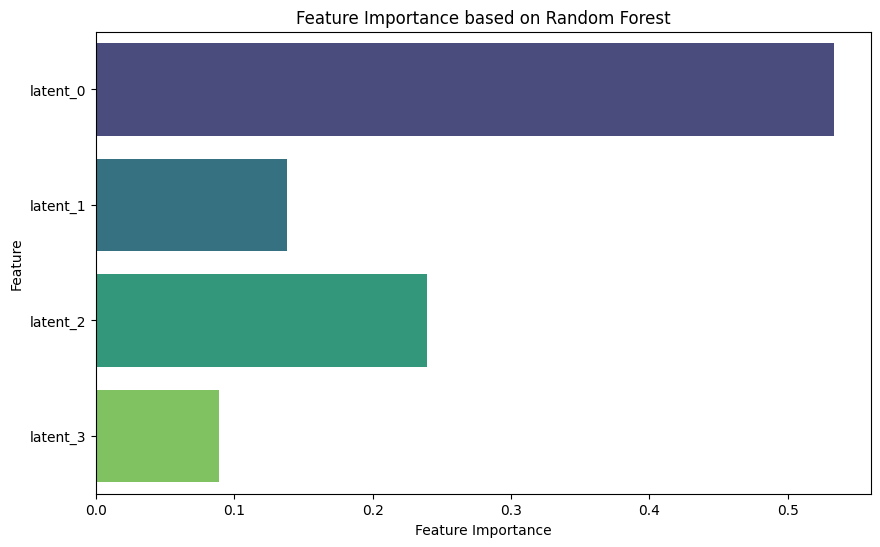

In [96]:
plot_feature_importance(latent_rep_scaled, n_clusters=5)

In [46]:
def plot_dendrogram(data, linkage_method, cut_line=None):
    """
    Plot a dendrogram for hierarchical clustering.

    Args:
        data (numpy.ndarray or pandas.DataFrame): The input data for clustering.
        linkage_method (str): The linkage method used for clustering.
        cut_line (float, optional): The threshold value to cut the dendrogram. Defaults to None.

    Returns:
        None
    """
    # Fit the AgglomerativeClustering model
    model = AgglomerativeClustering(linkage=linkage_method, distance_threshold=0, n_clusters=None).fit(data)

    # Create the plot
    fig, ax = plt.subplots()
    plt.title('Hierarchical Clustering Dendrogram')

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create the linkage matrix
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the dendrogram
    dendrogram(linkage_matrix, truncate_mode='level', p=50)

    # Add a cut line if provided
    if cut_line is not None:
        plt.axhline(y=cut_line, color='black', linestyle='-')

    # Display the plot
    plt.show()

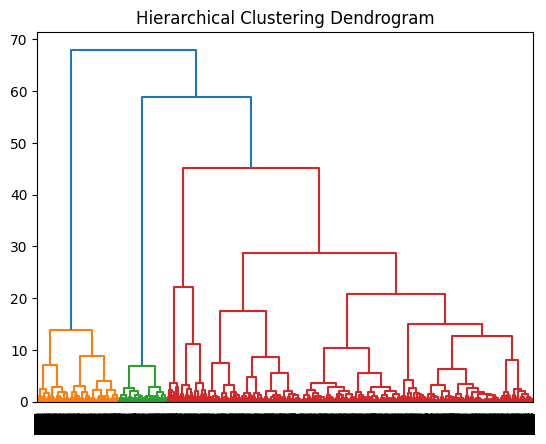

In [52]:
plot_dendrogram(latent_rep_scaled, 'ward')

In [36]:
latent_rep_scaled_labeled = latent_rep_scaled.copy()
latent_rep_scaled_labeled['cluster'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 9
    ).fit_predict(latent_rep_scaled)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


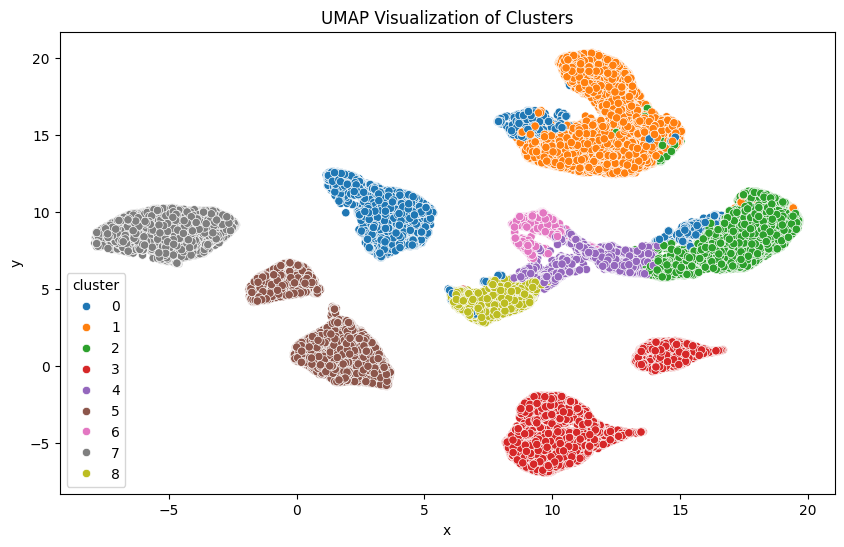

In [37]:
plot_umap_clusters(latent_rep_scaled_labeled)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


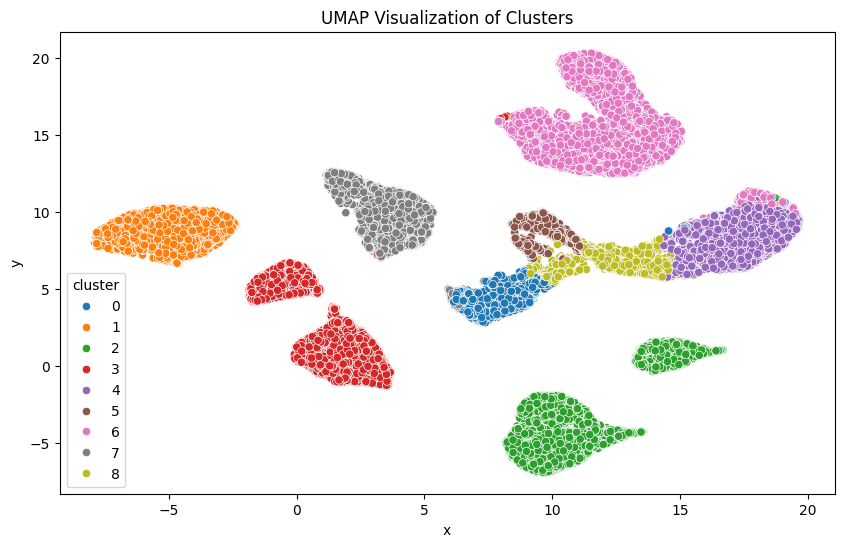

In [33]:
latent_rep_scaled_labeled2, kmeans = append_kmeans_clusters(latent_rep_scaled, n_clusters=9)
#centroids_non_outliers = kmeans.cluster_centers_
plot_umap_clusters(latent_rep_scaled_labeled2)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


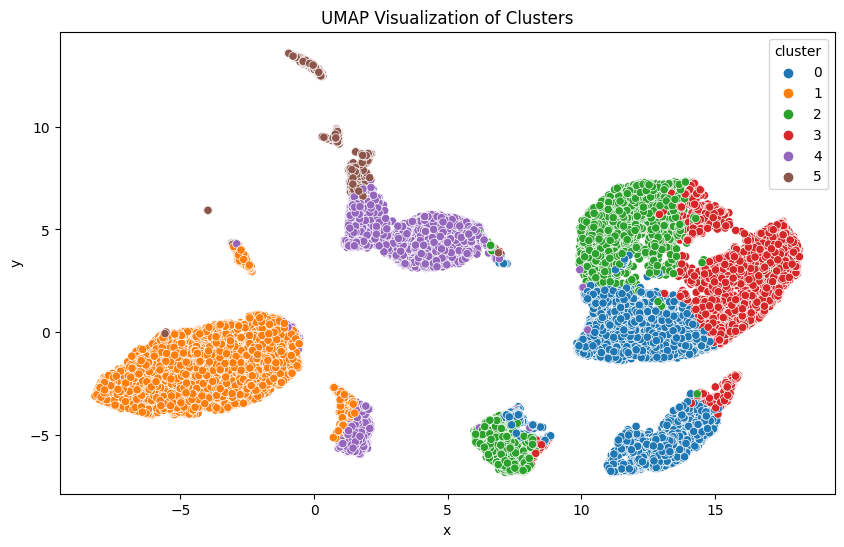

In [39]:
latent_rep_scaled_labeled_outliers, kmeans_outliers = append_kmeans_clusters(latent_rep_scaled_outliers, n_clusters=6)
centroids_outliers = kmeans_outliers.cluster_centers_
plot_umap_clusters(latent_rep_scaled_labeled_outliers)

**Concat**

In [21]:
merge_decisions, nearest_clusters = evaluate_and_merge_outliers(latent_rep_scaled_labeled_outliers.drop(columns=['cluster']), centroids_non_outliers, threshold=0.5)

latent_df_outliers = update_cluster_labels(latent_rep_scaled_labeled_outliers, merge_decisions, nearest_clusters, n_clusters_non_outliers=7)

combined_latent_df = pd.concat([latent_rep_scaled_labeled, latent_df_outliers], ignore_index=True)
combined_latent_df.head()

,latent_0,latent_1,latent_2,latent_3,cluster
0,0.789207,0.185843,0.595078,0.218777,4
1,0.476100,0.105589,0.601062,0.370229,1
2,0.710481,0.426843,0.336404,0.176330,3
3,0.382979,0.394682,0.559210,0.438602,0
4,0.398857,0.286276,0.764767,0.362277,1


c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


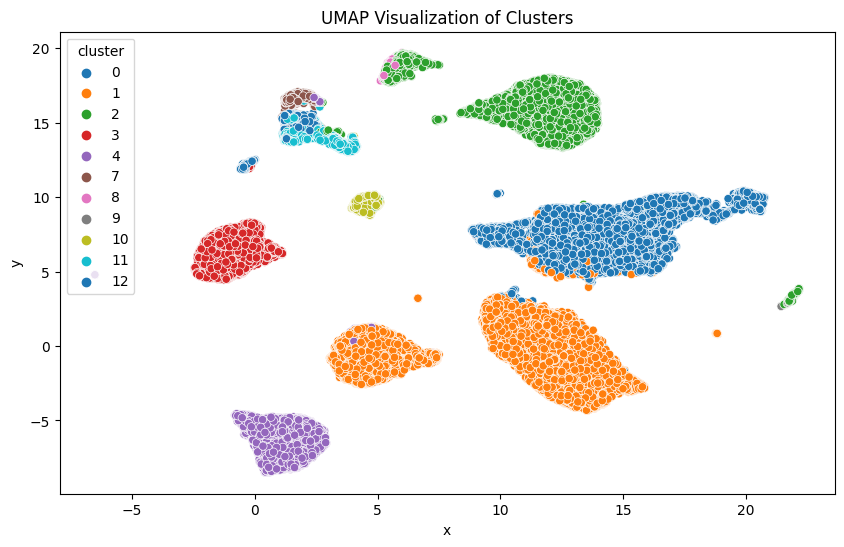

In [22]:
plot_umap_clusters(combined_latent_df)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


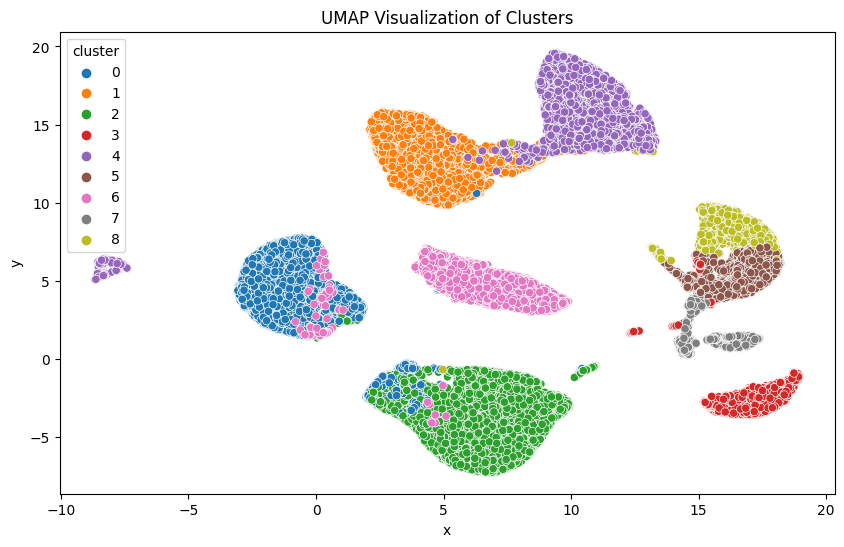

In [103]:
concat_latent_rep = adjust_and_concat_clusters(latent_rep_scaled_labeled, latent_rep_scaled_labeled_outliers)
plot_umap_clusters(concat_latent_rep)

**Without Autoencoder**

In [145]:
preproc_path = os.path.join(base_dir, 'customer_info_preproc.csv')
customer_info_preproc = pd.read_csv(preproc_path, index_col='customer_id')

preproc_path_outliers = os.path.join(base_dir, 'customer_info_preproc_outliers.csv')
customer_info_prepro_outliers = pd.read_csv(preproc_path_outliers, index_col='customer_id')

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


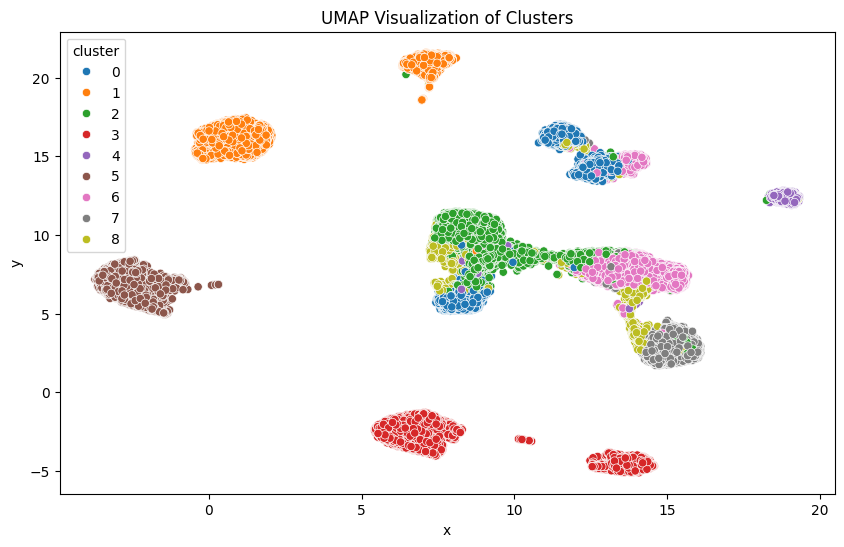

In [38]:
customer_info_preproc_labeled = customer_info_preproc.copy()
customer_info_preproc_labeled['cluster'] = AgglomerativeClustering(
    linkage = 'ward', n_clusters = 9
    ).fit_predict(customer_info_preproc)

plot_umap_clusters(customer_info_preproc_labeled)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


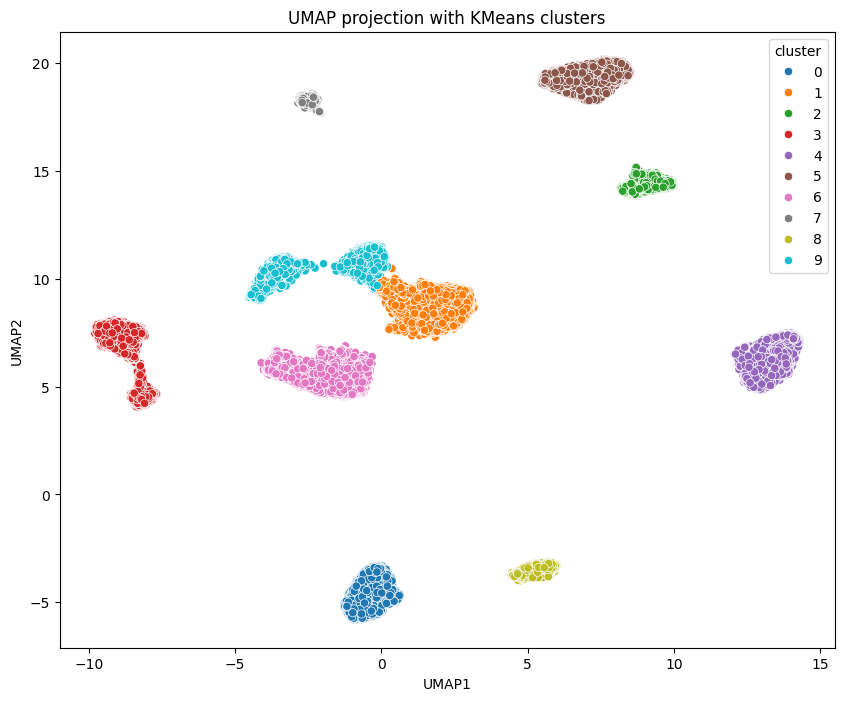

In [160]:
umap_reducer = umap.UMAP(n_neighbors=35, min_dist=0.0, n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(customer_info_preproc.drop(columns=['percentage_of_products_bought_promotion', 'spend_nonalcohol_drinks_proportion']))

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
umap_df['cluster'] = kmeans_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=umap_df, palette='tab10')
plt.title('UMAP projection with KMeans clusters')
plt.show()

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


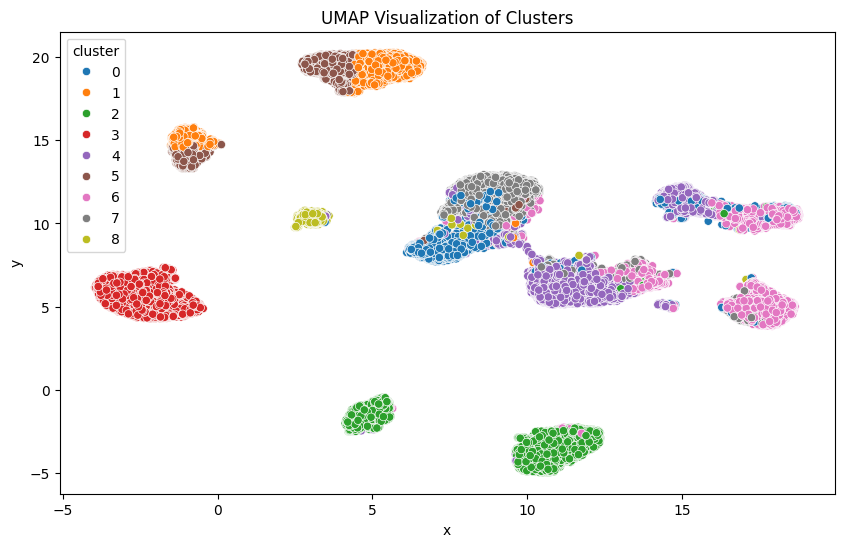

In [61]:
customer_info_preproc_labeled2, kmeans = append_kmeans_clusters(customer_info_preproc, n_clusters=9)
#centroids_non_outliers = kmeans.cluster_centers_
plot_umap_clusters(customer_info_preproc_labeled2)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


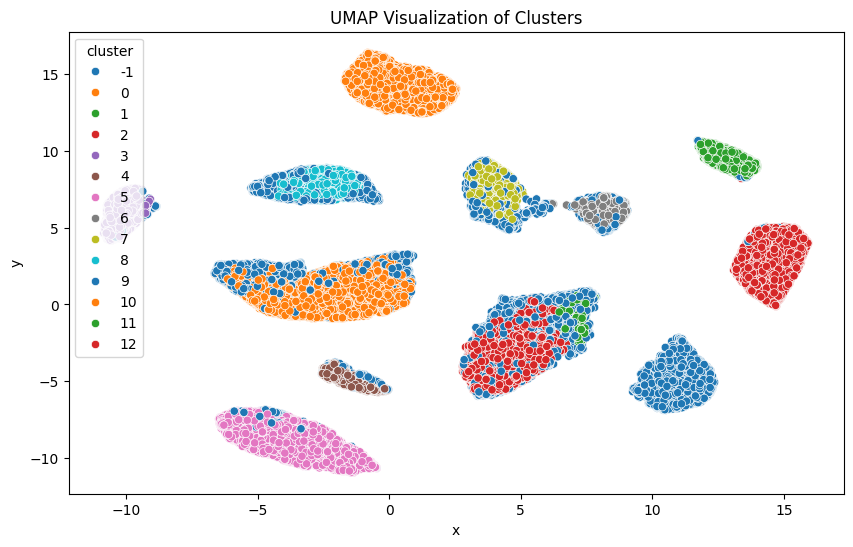

In [170]:
clusterer = HDBSCAN(min_cluster_size=200, min_samples=1)
cluster_labels = clusterer.fit_predict(latent_rep_scaled)
hdbscan_df = latent_rep_scaled.copy()
hdbscan_df['cluster'] = cluster_labels

plot_umap_clusters(hdbscan_df)

In [127]:
# filter by variance
good_features = customer_info_preproc.columns[customer_info_preproc.var() > 0.025]
customer_info_preproc_filtered = customer_info_preproc[good_features]
print(f'different features: {customer_info_preproc.shape[1] - customer_info_preproc_filtered.shape[1]}')
customer_info_preproc_filtered.head()

different features: 8


,typical_hour,frequency,monetary,spend_electronics_proportion,spend_vegetables_proportion,spend_meat_proportion,spend_fish_proportion,spend_videogames_proportion
customer_id,,,,,,,,
39634,0.683251,0.346410,0.806416,0.544071,0.169909,0.385148,0.492304,0.509045
43460,0.154701,0.282843,0.425870,0.378773,0.230161,0.428656,0.544952,0.417477
23937,0.290994,0.600000,0.449653,0.637666,0.207430,0.266886,0.579741,0.486514
2431,0.683251,0.000000,0.420380,0.150524,0.154852,0.223390,0.153975,0.000000
10090,0.807392,0.200000,0.153177,0.438073,0.062102,0.170540,0.288214,0.344030


c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


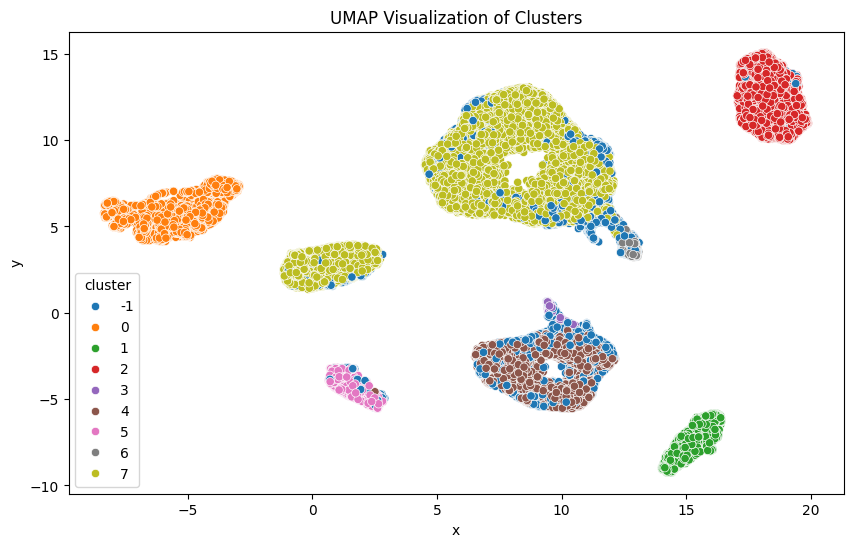

In [136]:
clusterer = HDBSCAN(min_cluster_size=200, min_samples=1, cluster_selection_epsilon=0.05)
cluster_labels = clusterer.fit_predict(customer_info_preproc_filtered)
hdbscan_df = customer_info_preproc_filtered.copy()
hdbscan_df['cluster'] = cluster_labels

plot_umap_clusters(hdbscan_df)